max: -1.6806654811608646 median: -8.041104027794596
max - median density for rank 1 6.360438546633731
percent near max for rank 1 0.03844224256866926
99th percentile for rank 1 -3.7438186215758047
max: -2.621281544350203 median: -7.9153591666402034
max - median density for rank 2 5.294077622290001
percent near max for rank 2 0.048601530164304525
99th percentile for rank 2 -4.011756423117108
max: -2.172005574843939 median: -7.761408306975465
max - median density for rank 3 5.589402732131526
percent near max for rank 3 0.0532421923993478
99th percentile for rank 3 -4.094240786307352
max: -1.6318734297075737 median: -7.808656450793081
max - median density for rank 4 6.176783021085507
percent near max for rank 4 0.05487269534679543
99th percentile for rank 4 -4.256826193599157
max: -1.3579714164126222 median: -7.705550509501873
max - median density for rank 5 6.3475790930892515
percent near max for rank 5 0.05850997115264016
99th percentile for rank 5 -4.37119684741413
max: 0.0 median: -6.

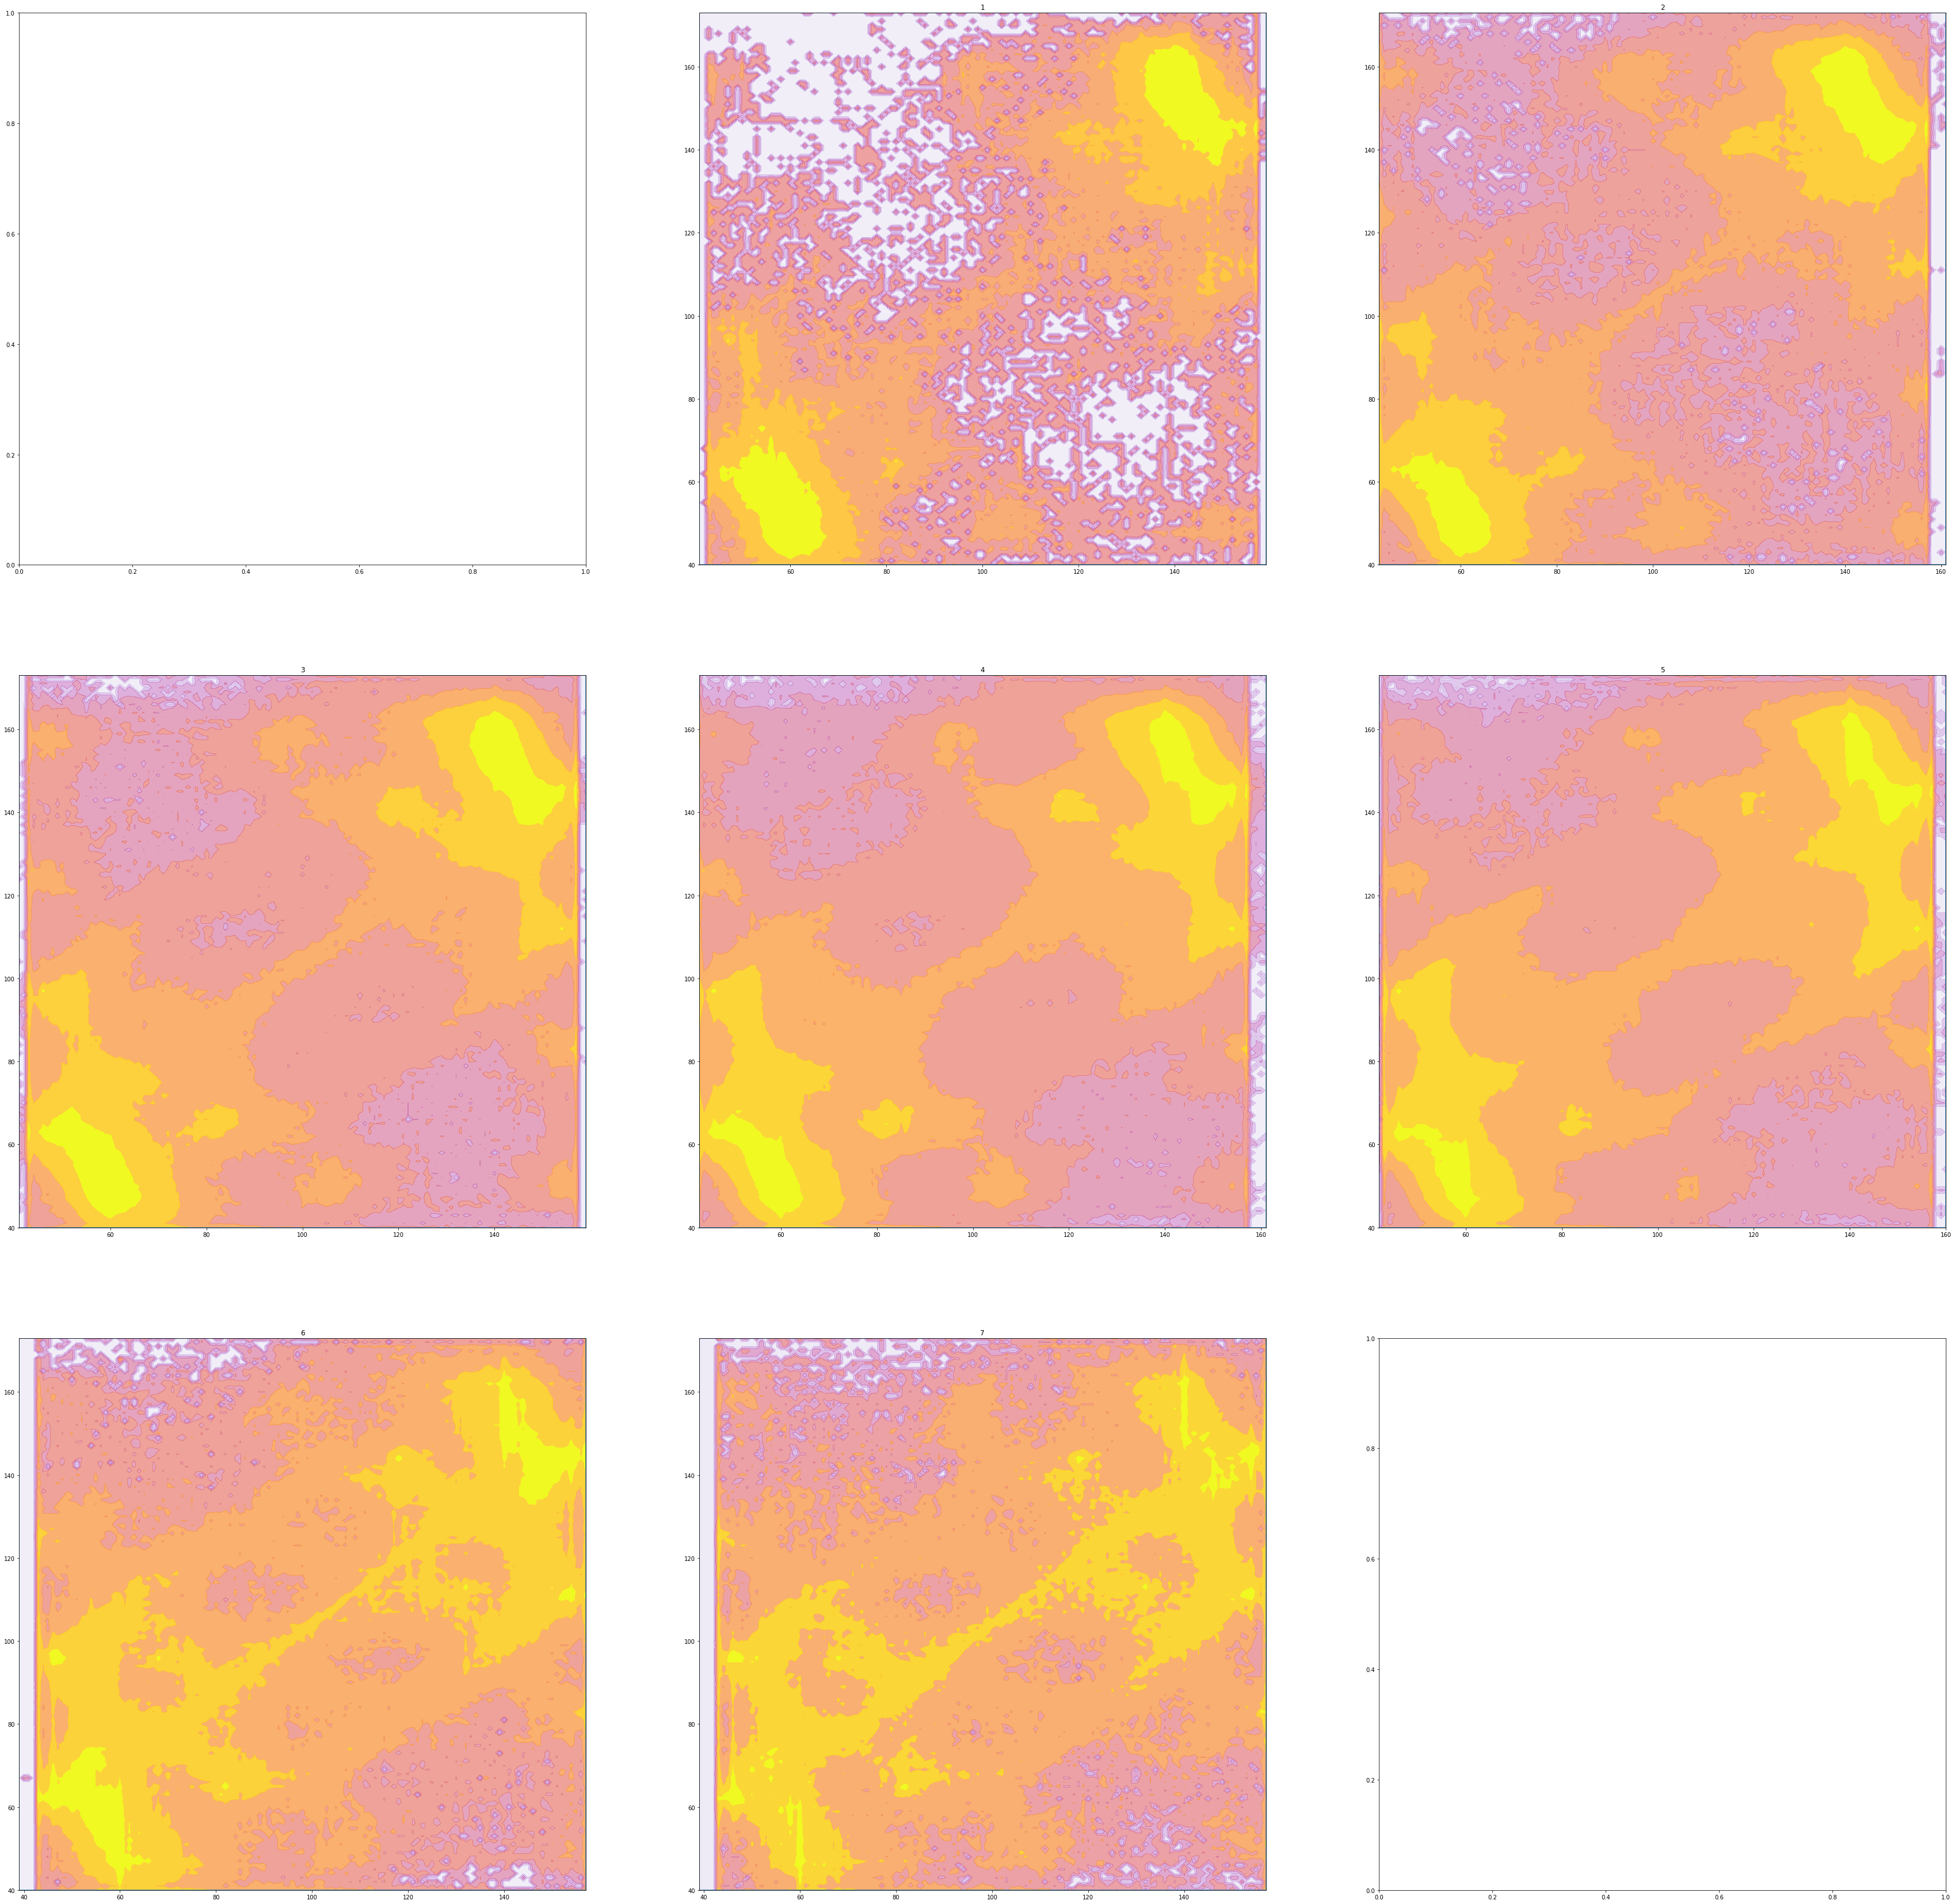

In [8]:
import csv
import ast
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from collections import defaultdict
from matplotlib.colors import ListedColormap
from scipy.special import expit
from random import random
import matplotlib
ranks = ['0', '1', '2', '3', '4', '5', '6', '7']
loc_lookup = {}
camera_events_count = defaultdict(int)
max_camera_event_count = 0
eternal_empire_ranks = {'7': 1062, '3': 1474, '0': 735, '4': 2941, '5': 3241, '2': 812, '6': 496, '1': 101}
blackburn_ranks = {'7': 188, '6': 33, '5': 214, '3': 171, '0': 74, '2': 51, '4': 162, '1': 15}
everdream_ranks = {'7': 711, '6': 309, '4': 2268, '5': 2878, '0': 651, '3': 1210, '2': 556, '1': 97}
with open("camera_locations2021-08-04.txt") as fp:
    cur_rank = None
    lookup = {}
    for line in fp:
        line = line.strip()
        if line in ranks:
            if cur_rank != None:
                loc_lookup[cur_rank] = lookup
                lookup = {}
            cur_rank = line
        else:
            loc, count = line.split(':')
            loc = ast.literal_eval(loc)
            count = int(count) / everdream_ranks[cur_rank]
            camera_events_count[cur_rank] += count
            max_camera_event_count = max(max_camera_event_count, count)
            lookup[loc] = count
    loc_lookup[cur_rank] = lookup
# map_img = plt.imread("Eternal_Empire.jpeg")
map_width = 138  # https://liquipedia.net/starcraft2/Eternal_Empire_LE
map_height = 141
camera_width = 20
camera_height = 8
heatmap_width = map_width - camera_width  # how wide the sc2 camera is
heatmap_height = map_height - camera_height  # how high the sc2 camera is


def find_heatmap_offset(heatmaps):
    best_regions = {}
    for rank in heatmaps:
        min_x = min(sorted({x for x, y in heatmaps[rank].keys()}))
        max_x = max(sorted({x for x, y in heatmaps[rank].keys()}))
        min_y = min(sorted({y for x, y in heatmaps[rank].keys()}))
        max_y = max(sorted({y for x, y in heatmaps[rank].keys()}))
        checked_regions = {}
        for x in range(min_x, max_x - heatmap_width + 1):
            for y in range(min_y, max_y - heatmap_height + 1):
                camera_events_inside = 0
                heatmap = heatmaps[rank]
                for camera_x, camera_y in heatmap.keys():
                    if camera_x >= x and camera_x < x + heatmap_width and camera_y >= y and camera_y < y + heatmap_height:
                        # this point is inside the current square we are checking
                        camera_events_inside += 1
                checked_regions[(x, y)] = camera_events_inside
        best_regions[rank] = max(checked_regions.items(), key=lambda item: item[1])[0]
    return best_regions


heatmap_offsets = find_heatmap_offset(loc_lookup)

cmap = cm.get_cmap("plasma")

# Get the colormap colors
my_cmap = cmap(np.arange(cmap.N))

# Set alpha
my_cmap[:, -1] = np.linspace(0, 1, cmap.N)

# Create new colormap
colormap = ListedColormap(my_cmap)
datapoints = []
fig = plt.figure(figsize=(60, 60))
subplots = fig.subplots(3, 3).flatten()[1:]
for desired_rank in ['1', '2', '3', '4', '5', '6', '7']:
    subplot = subplots[int(desired_rank) - 1]
    subplot.title.set_text(desired_rank)
    heatmap_x, heatmap_y = heatmap_offsets[desired_rank]
    min_x = min(sorted({x for x, y in loc_lookup[desired_rank].keys()}))
    max_x = max(sorted({x for x, y in loc_lookup[desired_rank].keys()}))
    min_y = min(sorted({y for x, y in loc_lookup[desired_rank].keys()}))
    max_y = max(sorted({y for x, y in loc_lookup[desired_rank].keys()}))
    subplot.axline((heatmap_x, heatmap_y), (heatmap_x, heatmap_y + heatmap_height))
    subplot.axline((heatmap_x + heatmap_width, heatmap_y), (heatmap_x + heatmap_width, heatmap_y + heatmap_height))
    subplot.axline((heatmap_x, heatmap_y), (heatmap_x + heatmap_width, heatmap_y))
    subplot.axline((heatmap_x, heatmap_y + heatmap_height), (heatmap_x + heatmap_width, heatmap_y + heatmap_height))
    i = 0
    x = np.arange(heatmap_x, heatmap_x + heatmap_width + 1, 1)
    y = np.arange(heatmap_y, heatmap_y + heatmap_height + 1, 1)
    z = np.zeros((len(y), len(x)))
    z.fill(0.000001)
    for (xloc, yloc), count in loc_lookup[desired_rank].items():
        i += 1
        print(f"{i} out of {len(loc_lookup[desired_rank])}", end="\r")
        adjusted_x = xloc - heatmap_x
        adjusted_y = yloc - heatmap_y
        density = count / max_camera_event_count
        if adjusted_x >= 0 and adjusted_x < z.shape[1] and adjusted_y >= 0 and adjusted_y < z.shape[0]:
            z[adjusted_y][adjusted_x] = density
    #         x.append((xloc - 28  + random() - 0.5 + offset_x) * xscale)
    #         y.append(2000 - (yloc - 20 + random() - 0.5 + offset_y) * yscale)
    z = np.log(z)
    print("max:", np.max(z), "median:", np.median(z))
    print("max - median density for rank", desired_rank, np.max(z) - np.median(z))
    print("percent near max for rank", desired_rank, np.count_nonzero(z >= (np.quantile(z, 0.99) * 1.2)) / z.size)
    print("99th percentile for rank", desired_rank, np.quantile(z, 0.99))
#     print("std among locs for rank", desired_rank,
#           np.std([loc for loc, count in loc_lookup[desired_rank].items() for _ in range(count)]))
    norm = cm.colors.Normalize(vmax=max_camera_event_count, vmin=0)
    datapoints.append({"Map": "EternalEmpireLE", "Rank": desired_rank, "Function": "Log", "Max": np.max(z), "Median": np.median(z), "PercentNearMax": np.count_nonzero(z >= (np.quantile(z, 0.99) * 1.2)) / z.size,
                      "99thPercentile": np.quantile(z, 0.99)})
    #subplot.imshow(map_img,origin="upper",alpha=0.4, extent=[min_x, max_x, min_y,max_y],interpolation="nearest")

    subplot.contourf(x, y, z, 10, cmap=colormap, vmax=np.quantile(z, 0.99))
    
with open("everdreamle.csv", 'w', newline='') as my_csv:
    events_out = csv.DictWriter(my_csv, fieldnames=["Map", "Rank", "Function", "Max", "Median", "PercentNearMax", "99thPercentile"])
    events_out.writeheader()
    for result in datapoints:
        events_out.writerow(result)
print()

In [1]:
import csv
import ast
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from collections import defaultdict
from matplotlib.colors import ListedColormap
from random import random

ranks = ['0', '1', '2', '3', '4', '5', '6', '7']
loc_lookup = {}
camera_events_count = defaultdict(int)
with open("camera_locations2021-08-02.txt") as fp:
    cur_rank = None
    lookup = {}
    for line in fp:
        line = line.strip()
        if line in ranks:
            if cur_rank != None:
                loc_lookup[cur_rank] = lookup
                lookup = {}
            cur_rank = line
        else:
            loc, count = line.split(':')
            loc = ast.literal_eval(loc)
            count = int(count)
            camera_events_count[cur_rank] += count
            lookup[loc] = count
cmap = cm.get_cmap("plasma")
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:, -1] = np.linspace(0, 1, cmap.N)
colormap = ListedColormap(my_cmap)


def find_heatmap_offset(heatmaps, map_width, map_height):
    best_regions = {}
    for rank in heatmaps:
        min_x = min(sorted({x for x, y in heatmaps[rank].keys()}))
        max_x = max(sorted({x for x, y in heatmaps[rank].keys()}))
        min_y = min(sorted({y for x, y in heatmaps[rank].keys()}))
        max_y = max(sorted({y for x, y in heatmaps[rank].keys()}))
        checked_regions = {}
        for x in range(min_x, max_x - map_width):
            for y in range(min_y, max_y - map_height):
                camera_events_inside = 0
                heatmap = heatmaps[rank]
                for camera_x, camera_y in heatmap.keys():
                    if camera_x >= x and camera_x < x + map_width and camera_y >= y and camera_y < y + map_height:
                        # this point is inside the current square we are checking
                        camera_events_inside += heatmap[(camera_x, camera_y)]
                checked_regions[(x, y)] = camera_events_inside
        best_regions[rank] = max(checked_regions.items(), key=lambda item: item[1])[0]
    return best_regions


print(find_heatmap_offset(loc_lookup, map_dim, map_dim))

map_img = plt.imread("Eternal_Empire.jpeg")
map_dim = 140  # https://liquipedia.net/starcraft2/Eternal_Empire_LE

fig = plt.figure(figsize=(60, 60))
subplots = fig.subplots(3, 3).flatten()[1:]
for desired_rank in ['2', '3', '4', '5', '6', '7']:
    subplot = subplots[int(desired_rank) - 3]
    subplot.title.set_text(desired_rank)
    heatmap_width = max_x - min_x
    heatmap_height = max_y - min_y
    offset_x = (map_dim - heatmap_width) / 2
    offset_y = (map_dim - heatmap_height) / 2
    # plt.axline((min_x * xscale, 0), (min_x * xscale, 2000))
    # plt.axline((max_x * xscale, 0), (max_x * xscale, 2000))
    # plt.axline((0, min_y * yscale), (2000, min_y * yscale))
    # plt.axline((0, max_y * yscale), (2000, max_y * yscale))
    i = 0
    x = np.arange(min_x, max_x, 1)
    y = np.arange(min_y, max_y, 1)
    print(len(x), len(y))
    z = np.zeros((len(y), len(x)))
    print(z.shape)
    z.fill(0.000001)
    for (xloc, yloc), count in loc_lookup[desired_rank].items():
        i += 1
        print(f"{i} out of {len(loc_lookup[desired_rank])}", end="\r")
        adjusted_x = xloc
        density = count / camera_events_count[desired_rank]
        if xloc >= 0 and xloc < z.shape[0] and yloc >= 0 and yloc < z.shape[1]:
            z[yloc][xloc] = density
    #         x.append((xloc - 28  + random() - 0.5 + offset_x) * xscale)
    #         y.append(2000 - (yloc - 20 + random() - 0.5 + offset_y) * yscale)
    norm = cm.colors.Normalize(vmax=np.amax(z), vmin=0)
    subplot.imshow(map_img, origin="upper", alpha=0.4, extent=[min_x, max_x, min_y, max_y], interpolation="nearest")

    subplot.contourf(x, y, np.log(z), 20, cmap=colormap)
    break
print()

NameError: name 'map_dim' is not defined